# Overview

This a notebook outlining an approach for modeling population growth using partial differential equations (PDEs). It is based on a synthetic dataset, in which I was given 50 years of population data -- population levels over each age group, for 50 years. I was asked to predict the distribution of ages for the next 30 years, in order to give an estimate of the number of children in each age group for school staffing purposes.

Note that this synthetic dataset is pretty simple -- not a lot of noise in the data, no unexpected influx of population. This allowed my model to perform better than would be expected with real data.

# 1: Visualize Data

In [29]:
from scipy.optimize import fsolve
from scipy.io import loadmat
import numpy as np
import pylab
from mpl_toolkits.mplot3d import axes3d

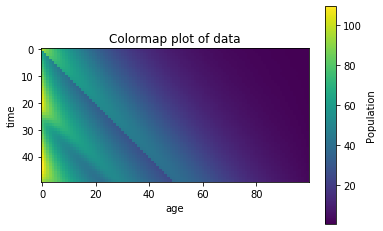

In [30]:
# Visualize the data given
pop_data = loadmat('population_density_data.mat')
pop_data = pop_data['M_students']
pylab.imshow(pop_data)
pylab.xlabel('age')
pylab.ylabel('time')
pylab.title("Colormap plot of data")
cbar = pylab.colorbar()
cbar.set_label("Population")
pylab.show()

This next plot is exactly the same, but using the z-axis to represent population, instead of color.

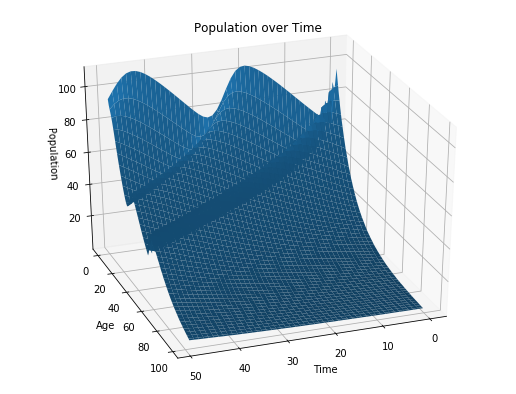

In [31]:
# Generate a 3d plot of the data
num_years, num_ages = pop_data.shape
x1 = np.arange(num_years)
x2 = np.arange(num_ages)
X1, X2 = np.meshgrid(x1, x2)
fig = pylab.figure(figsize=(9, 7))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(X1.T, X2.T, pop_data)
pylab.title('Population over Time')
pylab.xlabel('Time')
pylab.ylabel('Age')
ax1.view_init(30, 70)
ax1.set_zlabel('Population')
pylab.show()

## 1.1 Observations

In visualizing the data, there were a couple of things that I noticed. 

One, I noticed that the population trends correspond to intuition from domain knowledge -- namely, there is a clear shift in the population each year, as the entire population ages by 1 year each year.

Two, I noticed that on top of the one-year shift, that a certain percentage of the population dies off each year, for each age group. This is why the population shift isn't constant over time -- the shift slopes down, because the population at each year depends on the population at the previous year, minus the individuals who died off.

Three, I noticed the "waves" of new births (the population at age 0) over time. I hypothesized that this is likely due to fluctuations in the population that falls in the childbearing range of ages.

# 2: Solve for birth rate and death rate

Based on the intuition that came from visualizing the data, I tested my hypotheses: 1) that a certain percentage of each age group dies off each year, and 2) that the number of new births was a function of the number of individuals in the childbearing age range.

## 2.1: Solve for the birth rate

I guessed that the number of new births would be a linear combination of the number of individuals of each age group - i.e. that there were a set of weights that, when multiplied by the number of individuals of each age, would give the number of new births. Thus, I set up a linear system of the form:

$A \textbf{r}=\textbf{p}$

where $A$ is matrix representing the population, defined as 

$A_{ij}=\text{population of age }j\text{ at year }i$, 

the vector $\textbf{r}$ is the vector of "reproduction coefficients", and $\textbf{p}$ is the "new births vector", defined as

$p_{i}=\text{number of births in year } i+1$

I set up the system of equations using the last 49 years of data and assumed that the reproduction coefficients were 0 for people ages 50 and older. Then I solved for the reproduction coefficients.

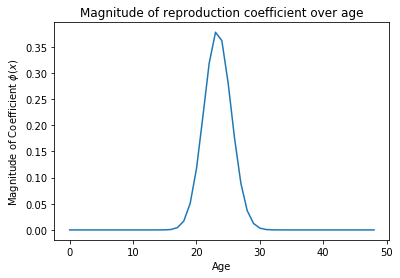

In [32]:
from scipy.optimize import fsolve
# We set up a system of equations to find the birth rate coefficients 
# of each age group, assuming only people age 0-50 reproduce

# The population data
age_pops = pop_data[:-1, :49]
# This is the vector that our population data maps to
births = pop_data[1:, 0]
repro_coeffs = np.linalg.solve(age_pops, births)

pylab.plot(np.arange(49), repro_coeffs)
pylab.title("Magnitude of reproduction coefficient over age")
pylab.ylabel("Magnitude of Coefficient $\phi(x)$")
pylab.xlabel("Age")
pylab.show()

From these we see that the reproduction coefficients are ~normally distributed with mean around age 24, which is plausible.

## 2.2 Solve for death rate

Solving for the death rate of each age group was easier. I subtracted the population of all age groups at one year $A_t^a$ from the population of the age groups one year older the next year $A_{t+1}^{a+1}$, then divided that by the original population $A_t^a$. The idea was that this would represent the percent change in population for each age group, year-over-year.

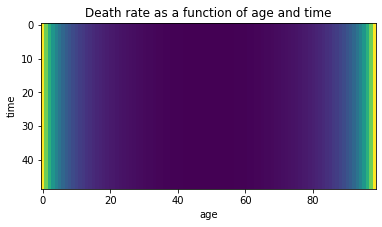

In [33]:
deaths_rate = (pop_data[:-1, :-1] - pop_data[1:, 1:]) / pop_data[:-1, :-1]
pylab.imshow(deaths_rate)
pylab.ylabel("time")
pylab.xlabel("age")
pylab.title("Death rate as a function of age and time")
pylab.show()

From this visualization, I saw that the death rate is invariant to time, so I plotted the death rate in one dimension:

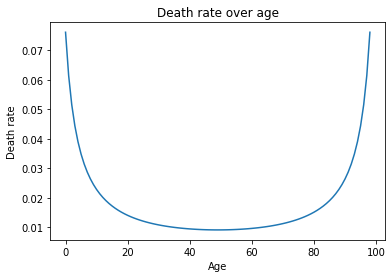

In [34]:
death_coeffs = np.mean(deaths_rate, axis=0)
pylab.plot(death_coeffs)
pylab.ylabel("Death rate")
pylab.xlabel("Age")
pylab.title("Death rate over age")
pylab.show()

# 3: Define a model

These are helpful insights, but how can they help build a model to project future population growth? My approach was to incorporate them into a PDE.

I reasoned that this data would be well-modeled with a transport equation of the form:

$p_t + p_x = f(p, x)$

because people age by 1 year each year. I also incorporated a term to account for a certain percentage of each age group dying each year. The death coefficient $a$ was found to be invariant to time, which is why it is a function of only x.

The final PDE was the following:

$p_t(x, t) = -p_x(x, t) - a(x)p(x, t)$

where x is age and t is time.

I also defined a boundary condition based on the birth rate:

$p_t(0, t) = \int_{10}^{45} \phi(x)p(x, t)$

The idea is that $\phi$ is a kernel (or 'window') function that gives the weight with which each age group affects the birth rate, and we sum over all those weighted values. I will use the coefficients that we solved for above as the window function $\phi$.

I also define a boundary condition for $t=0$ that is given by our data:

$p_t(x, 0) = p[:, 0]$

I implemented the PDE with a forward difference scheme that has been proven to be well-conditioned:

\begin{equation}
\frac{p_j^{i+1} - p_j^i}{\Delta t}= -\frac{p_j^i - p_{j-1}^i}{\Delta x} - a_j p_{j-1}^i.
\end{equation}

Letting $\Delta t, \Delta x = 1$ and simplifying, we have:

\begin{equation}
p_j^{i+1} = p_{j-1}^i - a_jp_{j-1}^i.
\end{equation}

# 4: Predict new data

Finally, I used this finite difference scheme to predict population levels for the next 30 years.

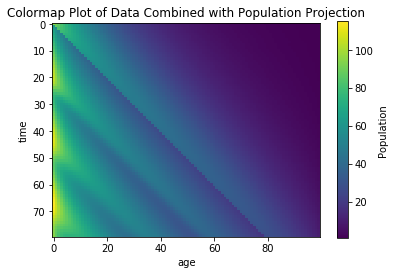

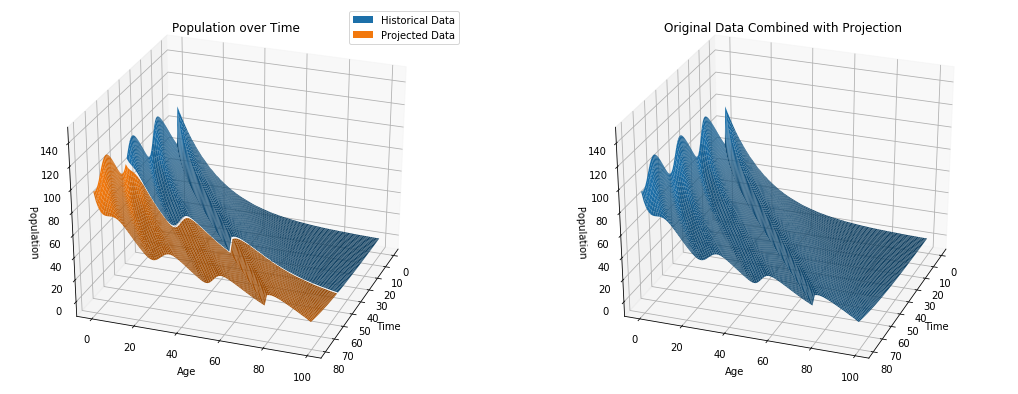

In [35]:
years_to_project = 30
max_age = 100
history = pop_data.shape[0]
plot_separately = True

# Add blank rows to data
future = np.zeros((years_to_project, max_age))
data = np.concatenate((pop_data, future), axis=0)

# Run the PDE forward in time using the backward difference scheme
for i in range(history-1, history+years_to_project-1):
    # Define the boundary condition
    new_births = np.dot(repro_coeffs, data[i, :49])
    data[i+1, 0] = new_births
    # Use the backward difference scheme to solve the rest of the PDE
    data[i+1, 1:] = data[i, :-1] - death_coeffs * data[i, :-1]
    
pylab.imshow(data)
pylab.xlabel('age')
pylab.ylabel('time')
pylab.title("Colormap Plot of Data Combined with Population Projection")
cbar = pylab.colorbar()
cbar.set_label("Population")

fig = pylab.figure(figsize=(18, 7))
ax1 = fig.add_subplot(121, projection='3d')

num_years, num_ages = pop_data.shape
x11 = np.arange(num_years)
x12 = np.arange(num_ages)
X11, X12 = np.meshgrid(x11, x12)
surf1 = ax1.plot_surface(X11.T, X12.T, data[:num_years, :], rstride=1, cstride=1, label="Historical Data")
# Hack to deal with matplotlib bug
surf1._facecolors2d=surf1._facecolors3d
surf1._edgecolors2d=surf1._edgecolors3d

x21 = np.arange(num_years, num_years + years_to_project)
x22 = np.arange(num_ages)
X21, X22 = np.meshgrid(x21, x22)
surf2 = ax1.plot_surface(X21.T, X22.T, data[num_years:, :], rstride=1, cstride=1, label="Projected Data")
surf2._facecolors2d=surf2._facecolors3d
surf2._edgecolors2d=surf2._edgecolors3d

pylab.title('Population over Time')
pylab.xlabel('Time')
pylab.ylabel('Age')
ax1.view_init(30, 20)
ax1.set_zlabel('Population')
ax1.set_zlim(-10, 150)
pylab.legend()

ax2 = fig.add_subplot(122, projection='3d')
x1 = np.arange(num_years + years_to_project)
x2 = np.arange(num_ages)
X1, X2 = np.meshgrid(x1, x2)
ax2.plot_surface(X1.T, X2.T, data, rstride=1, cstride=1, label="Historical Data")

pylab.title('Original Data Combined with Projection')
pylab.xlabel('Time')
pylab.ylabel('Age')
ax2.view_init(30, 20)
ax2.set_zlabel('Population')
ax2.set_zlim(-10, 150)
pylab.show()    

# 5: Conclusion

Empirically, this model performed well. It seemed to continue the patterns present in the original data. It also performed well on the witheld test set (error on the order of 1e-13). This is remarkable given the difficulty of extrapolation.

Drawbacks:

That said, this is synthetic data designed to capture only some aspects of real-world population growth phenomena. A model made to fit real data is unlikely to perform nearly as well. Furthermore, this problem fell into a relatively narrow domain of problems that can be modeled well with PDEs. PDEs, in their traditional use, are not universal function approximators like neural networks are (though there are ways to design more robust PDEs, see e.g. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5312119/)

Positives:

However, there are some good takeaways from this problem. First, PDEs are generally designed to model real world phenomena and intuition (in this case, death rates, birth rates, and aging). They allow the designer to incorporate a large amount of domain knowledge that would be difficult to incorporate into, say, a machine learning model. They are also simpler models than many machine learning models, making them more resistant to overfitting. I believe this is why the model extrapolated so well -- because the only learned parameters were the reproduction coefficients and death rates.

Future Questions:

Neural networks and other machine learning methods are generally good at interpolation, but notoriously poor at extrapolation to out-of-distribution data points. I suspect that a machine learning model would have a hard time extrapolating population growth, but it would be interesting to train a machine learning model (a Kalman Filter, ARMA model, or neural network) on the same data and compare the results.

In [36]:
pylab.savefig('pop_proj.png')

<Figure size 432x288 with 0 Axes>